In [2]:
from argparse import ArgumentParser
import os
import sys
import time

# import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import xarray as xr

# from matplotlib import colors
from pandarallel import pandarallel
# from shapely.geometry import box

from reaches import *
from utils import *

### Parse arguments

In [ ]:
# parser = ArgumentParser(description='Please specify whether you would\
#                         like to use the min, mean, or max predicted\
#                         bankfull width for this analysis.')
# parser.add_argument('width_set', type=str, help='min, mean, or max')
# args=parser.parse_args()
# width_set = args.width_set

In [3]:
# FOR NOW, SET
width_set = 'min'

# Control flow
if width_set == 'mean':
    width = 'WidthM'
elif width_set == 'min':
    width = 'WidthM_Min'
elif width_set == 'max':
    width = 'WidthM_Max'
else:
    print('Invalid width option specified, exiting.')
    # sys.exit()

### Pixel Cloud

In [4]:
# Get PIXC index metadata
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
dtype_dic= {'cycle': str, 'pass': str, 'tile': str, 'version': str}

# Read in HUC lookup table
pixc_lookup = pd.read_csv(os.path.join(mdata_path,
                                  'PIXC_v2_0_HUC2_01_best_files_no_exits.csv'),
                     dtype=dtype_dic).drop(columns='index')

In [5]:
# Get job index
# slurm = int(os.environ['SLURM_ARRAY_TASK_ID'])
slurm = 0 # 3032

In [6]:
# Get filepath for this tile
file_name = pixc_lookup.loc[slurm, 'files']
granule_name = file_name[:-3]
tile_name = file_name[20:28]
pass_num = int(file_name[20:23])

#### Read in PIXC

In [7]:
# Set PIXC filepath
data_path = '/nas/cee-water/cjgleason/fiona/data/PIXC_v2_0_HUC2_01/'
pixc_path = os.path.join(data_path, file_name)

In [8]:
# Read in pixel group
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group = 'pixel_cloud', engine='h5netcdf')

In [9]:
# Make mask
mask = bitwiseMask(ds_PIXC)

if mask.shape[0] == 0:
    print('This granule has no pixels after masking, exiting.')
    # sys.exit(1)    

(288527,)


In [10]:
# Set desired data vars
variables = ['azimuth_index', 'range_index', 'cross_track',
             'pixel_area', 'height', 'geoid',
             'dlatitude_dphase', 'dlongitude_dphase',
             'dheight_dphase', 'classification']

In [11]:
# Make PIXC into GeoDataFrame
gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_vars=variables)

### Find correct HUC4s

In [12]:
# Read in tile and HUC4 intersection data
dtype_dic= {'tile': str, 'huc4': str, 'coverage': float}
tile_huc4 = pd.read_csv(os.path.join(mdata_path,
                                    'huc4_swot_science_tiles.csv'),
                        dtype=dtype_dic)

In [13]:
# Make list of HUC4s that intersect our tile
hucs = list(tile_huc4[tile_huc4['tile'] == tile_name]['huc4'])

In [14]:
hucs

['0101']

In [15]:
# Get NHD index metadata
# Define dtypes for lookup tables to preserve leading zeros
dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# Read in HUC lookup table
huc_lookup = pd.read_csv(os.path.join(mdata_path,
                                  'HUC4_lookup_no_great_lakes.csv'),
                     dtype=dtype_dic)

In [16]:
# Extract indices for read-in
indices = list(huc_lookup[huc_lookup['HUC4'].isin(hucs)]['slurm_index'])

### Read in HUC4 flowliness

In [17]:
# Create merged dataframe of all flowliness intersected
if len(indices) == 1:
    # Read prepped NHD
    flowlines, huc4_list, huc2_list = readNHD(index=indices[0])

else:
    # Initialize lists
    d = []
    huc4_list = []
    huc2_list = []
    
    # Loop through indices and store in lists
    for i in indices:

        # Read prepped NHD
        flowlines, huc4, huc2 = readNHD(index=i)

        # Append to lists
        d.append(flowlines)
        huc4_list.append(huc4)
        huc2_list.append(huc2)
        
    # Merge GeoDataFrames
    flowlines = pd.concat(d)

NHDPLUS_H_0101_HU4_GDB
read in
exploded


In [18]:
# Project CRS (currently to WGS 84 / UTM zone 18N)
flowlines = flowlines.to_crs(epsg=32618)

In [19]:
pandarallel.initialize()

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [20]:
# xxx HOW TO MAKE THIS FASTER?
# Buffer with an extra 50 m on each side to be safe
# This is beyond the max distance that the pixels
# could extend once converted to pseudo pixels
# start = time.time()
# flowlines['buffer'] = flowlines.buffer(distance=((flowlines.WidthM/2)+50), cap_style='flat')
# end = time.time()
# print(end - start)
# #  = 

In [21]:
start = time.time()
flowlines['buffer'] = flowlines.parallel_apply(user_defined_function=specialBuffer,
                                                         args=(width,
                                                               'flat', False, True),
                                                         axis=1)
end = time.time()
print(end - start)

6.659667730331421


In [22]:
# Set geometry to buffered reaches
flowlines = flowlines.set_geometry('buffer').set_crs(epsg=32618)

In [23]:
# flowlines.crs

In [24]:
# Clip masked pixels to buffered reaches
gdf_PIXC_clip = gpd.sjoin(gdf_PIXC, flowlines, how='inner', predicate='within')

In [25]:
if gdf_PIXC_clip.shape[0] == 0:
    print('This granule has no pixels that intersect reaches, exiting.')
    # sys.exit() 

In [26]:
# Drop unneeded cols
gdf_PIXC_clip = gdf_PIXC_clip.drop(columns=['index_right',
                                            'Bin', 'GNIS_Name',
                                            'LengthKM', 'NHDPlusID',
                                            'WidthM', 'geometry_right'])

In [27]:
# gdf_PIXC_clip

### Nadir track

In [28]:
# Get single pixel for selecting correct nadir segment
pixel_pt = gdf_PIXC_clip.iloc[0].geometry

In [29]:
# Find correct nadir segment and return its geometry
nadir_segment_ln = findNadir(pass_num=pass_num, pixel_pt=pixel_pt)

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Make pseudo pixels

In [30]:
# Set along-track pixel resolution
azimuth_res = 21 # meters

In [31]:
# Make pseudo pixels
start = time.time()
gdf_PIXC_clip['pseudo_pixel'] = gdf_PIXC_clip.parallel_apply(user_defined_function=makePseudoPixels,
                                                         args=(nadir_segment_ln,
                                                               azimuth_res),
                                                         axis=1)
end = time.time()
print(end - start)

5.5033180713653564


In [32]:
# fig, ax = plt.subplots(figsize=(8,8))
# gdf_PIXC_clip.iloc[5:10]['pseudo_pixel'].plot(ax=ax, alpha=0.5, color='y')
# gdf_PIXC_clip.iloc[5:10].plot(ax=ax, markersize=5, color='hotpink')

In [33]:
# xxxWHY NOT JUST KEEP THE SAME DATA FRAME AND DROP THE UNWANTED COLS?
# pseudo = gdf_PIXC_clip.drop(columns='geometry').set_geometry('pseudo_pixel').set_crs(crs=gdf_PIXC_clip.crs)
gdf_PIXC_clip = gdf_PIXC_clip.rename(columns={'geometry': 'pixel_centroid'}).set_geometry('pseudo_pixel')

In [34]:
# Get bounds of PIXC tile
pseudo_bounds = gdf_PIXC_clip.total_bounds
# Copy geometry column as sjoin will discard it
gdf_PIXC_clip['pseudo_geom'] = gdf_PIXC_clip.geometry
# pseudo_poly = box(pseudo_bounds[0], pseudo_bounds[1],
#                       pseudo_bounds[2], pseudo_bounds[3])
# gdf_pseudo_bounds = gpd.GeoDataFrame({'geometry': [pseudo_bounds]}, crs=pseudo.crs)

In [35]:
# save_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/PIXC_v2_0_pseudo_pixels_filtered/'

In [36]:
# gdf_PIXC.to_parquet(path=save_path + granule_name + '.parquet')

### Read in segments

In [37]:
# Create merged dataframe of all basins intersected
if len(indices) == 1:
    # Read prepped NHD
    segments, _, _ = readNHD(index=indices[0], segmented=True)
else:
    # Initialize lists
    d = []
    # Loop through indices and store in lists
    for i in indices:
        # Read prepped NHD
        segments, huc4, _ = readNHD(index=i, segmented=True)
        # Make column with HUC4 id
        segments['huc4_long'] = huc4
        segments['huc4'] = segments['huc4_long'].str[10:14]
        # Rename segments to geometry
        segments = segments.rename(columns={'segments': 'geometry'}).set_geometry('geometry')
        # Append to list
        d.append(segments)
    # Merge GeoDataFrames
    segments = pd.concat(d)

NHDPLUS_H_0101_HU4_GDB
read in


In [38]:
# # Cast objects to string type so they aren't dropped in groupby()
# segments['Bin'] = segments['Bin'].astype('|S')
# segments['GNIS_Name'] = segments['GNIS_Name'].astype(str).str.encode('utf-8', errors='replace').str.decode('utf-8')

In [39]:
# segments['GNIS_Name'] = segments['GNIS_Name'].astype('|S')

In [40]:
# Project CRS (currently to WGS 84 / UTM zone 18N)
segments = segments.to_crs(epsg='32618')

<Axes: >

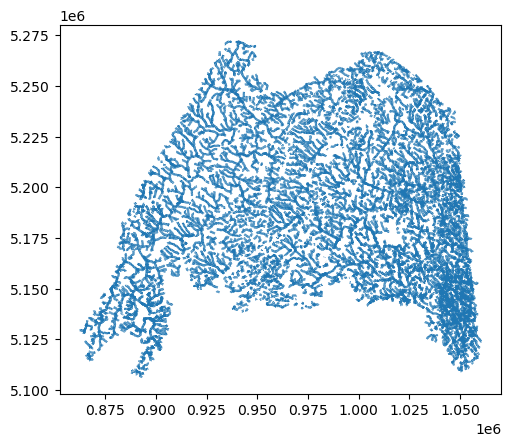

In [42]:
segments.plot()

In [43]:
segments = segments.reset_index().rename(columns={'index': 'index_old'})

In [44]:
# Assign a unique counter within each index group
segments['counter'] = segments.groupby('NHDPlusID').cumcount()

In [45]:
# Keep only first ten segments (some reaches repeat)
segments = segments[segments['counter'] < 10]

# For HUC4_0109, 5000700035256 and 5000700072690

<Axes: >

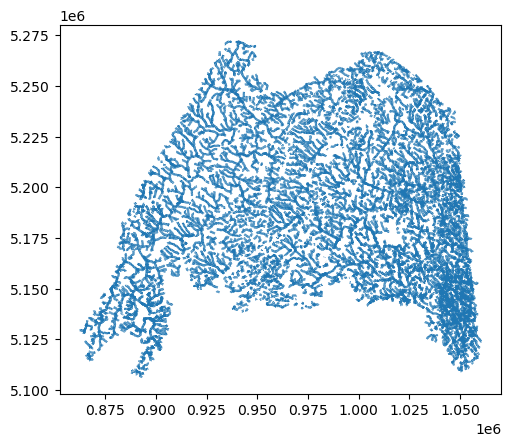

In [48]:
segments.plot()

In [49]:
segments = segments.clip(pseudo_bounds)

<Axes: >

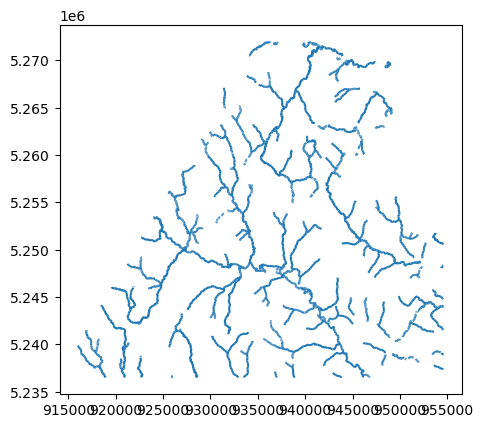

In [50]:
segments.plot()

In [51]:
# Keep only reaches that are fully contained in PIXC granule
segments = segments.groupby('NHDPlusID').filter(lambda x: len(x) == 10)

<Axes: >

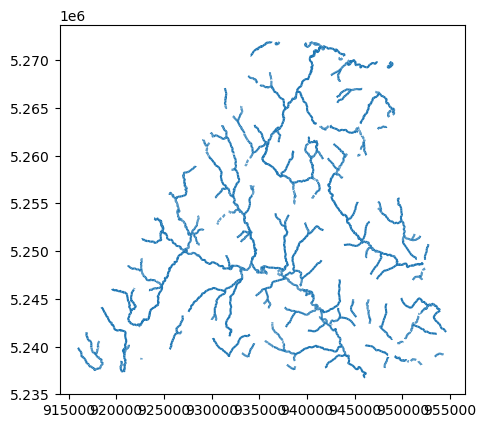

In [52]:
segments.plot()

In [58]:
segments.iloc[0]

index_old                                                 4671
Bin                                                    (0, 10]
GNIS_Name                                         Moores Brook
LengthKM                                                 2.742
NHDPlusID                                      5000100014596.0
WidthM                                                6.626968
segments     LINESTRING (941888.0941760535 5237803.81587108...
counter                                                      0
Name: 46710, dtype: object

In [53]:
# Buffer segments
## PARALLELIZE
start = time.time()
segments['buffer'] = segments.parallel_apply(user_defined_function=specialBuffer,
                                                         args=(width,
                                                               'flat', True, False),
                                                         axis=1)
end = time.time()
print(end - start)
# segments['buffered'] = segments.buffer(distance=(segments.WidthM/2), cap_style='flat')

AttributeError: 'Series' object has no attribute 'geometry'

In [ ]:
segments = segments.set_geometry('buffer')

In [ ]:
# Calculate segment area
segments['segment_area'] = segments.geometry.area

In [ ]:
# segments.sort_values(['NHDPlusID', 'counter'])

In [ ]:
# segments_buff = segments.geometry.buffer(distance=(segments.WidthM/2), cap_style='flat')

In [ ]:
# segment_bounds = segments_buff.bounds

In [ ]:
# ## Clip the pseudo pixels to the bounds of the reach
# pseudo_all = pseudo.union_all()

In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))
# pseudo.plot(ax=ax, column='klass')
# segments.plot(ax=ax, color='k', alpha=0.6)
# plt.xlim(824000, 826000)
# plt.ylim(4741000, 4743000)

In [ ]:
# Merge the segments and pseudo-puxels by intersection
sj = gpd.sjoin(segments, gdf_PIXC_clip, how='left', predicate='intersects')

In [ ]:
sj = sj.drop(columns=['index_right', 'points', 'azimuth_index',
                      'range_index', 'cross_track', 'pixel_area',
                      'height', 'geoid', 'dlatitude_dphase',
                      'dlongitude_dphase', 'dheight_dphase',
                      'klass', 'latitude', 'longitude', ])

In [ ]:
sj = sj.set_geometry('pseudo_geom')

In [ ]:
sj = sj.groupby('NHDPlusID', as_index=False).parallel_apply(user_defined_function=specialDissolve)

In [ ]:
sj = sj.reset_index().drop(columns=['level_0', 'level_1'])

In [ ]:
# def specialClip(df):
#     '''
#     XXX
#     '''
#     left = gpd.GeoSeries(df.pseudo_geom)
#     right = gpd.GeoSeries(df.buffer)
#     pseudo_geom_clip = left.clip(right)
#     return pseudo_geom_clip

In [ ]:
sj['pseudo_geom_clip'] = sj.parallel_apply(user_defined_function=specialClip,
                                                         axis=1)

In [ ]:
# sj[sj['NHDPlusID'] == 10000900090399].pseudo_geom.plot(cmap='hsv')

In [ ]:
# Calculate the pseudo-pixel area within each node
sj['pseudo_area'] = sj.pseudo_geom_clip.area

In [ ]:
sj['coverage'] = sj.pseudo_area/sj.segment_area

In [ ]:
sj_w_zero = sj.copy()

In [ ]:
sj_w_zero['coverage'] = sj_w_zero['coverage'].fillna(0)

In [ ]:
# mask = sj.duplicated(subset=('NHDPlusID', 'counter'), keep=False)

In [ ]:
# sj[mask][['NHDPlusID', 'counter', 'overlap_area']]

In [ ]:
# dupe_mask = sj.duplicated(subset=['NHDPlusID', 'counter'], keep=False)

In [ ]:
# sj[dupe_mask].segment_area

In [ ]:
# len(sj[dupe_mask].index.unique())

In [ ]:
# sj = sj.groupby(['NHDPlusID', 'counter'], as_index=False).sum('overlap_area')

In [ ]:
# sj.sort_values(by=['NHDPlusID', 'counter'])

In [ ]:
# sj['coverage'] = sj.overlap_area/sj.segment_area

In [ ]:
# sj.sort_values(by=['NHDPlusID', 'counter'])

In [ ]:
# sj[sj['overlap_area'] > 0].sort_values(['index_old', 'counter'])

In [ ]:
# Merge back on Bin and GNIS_Name (dropped in groupby because they are objects)
# sj = pd.merge(left=sj, right=flowlines[['NHDPlusID', 'Bin', 'GNIS_Name']], on='NHDPlusID', how='left')

In [ ]:
# sj = sj.rename(columns={'Bin_x': 'Bin', 'GNIS_Name_x': 'GNIS_Name'}).drop(columns=['Bin_y', 'GNIS_Name_y'])

### Do stats

In [ ]:
bins = sj.Bin.unique()

#### Nodes

In [ ]:
# nodes_mean = sj.groupby('Bin')['coverage'].mean().to_list()

In [ ]:
# nodes_std = sj.groupby('Bin')['coverage'].std().to_list()

In [ ]:
# nodes_count = sj.groupby('Bin')['coverage'].count().to_list()

In [ ]:
node_desc = sj.groupby('Bin')['coverage'].describe().reset_index()
node_desc['with_zero'] = 0

In [ ]:
node_quant = pd.DataFrame(sj.groupby('Bin')['coverage'].quantile(q=[x / 100.0 for x in range(0,100,1)])).reset_index().rename(columns={'level_1': 'quantile'})
node_quant['with_zero'] = 0

In [ ]:
# plt.errorbar(x=node_desc.Bin, y=node_desc['mean'], yerr=node_desc['std'])

In [ ]:
# d = {'mean': nodes_mean, 'std': nodes_std, 'count': nodes_count}

In [ ]:
# nodes = pd.DataFrame(data=d).T

In [ ]:
# nodes.columns = bins

#### Nodes with zeros

In [ ]:
node_desc_w_zero = sj_w_zero.groupby('Bin')['coverage'].describe().reset_index()
node_desc_w_zero['with_zero'] = 1
node_desc_w_zero

In [ ]:
node_quant_w_zero = pd.DataFrame(sj_w_zero.groupby('Bin')['coverage'].quantile(q=[x / 100.0 for x in range(0,100,1)])).reset_index().rename(columns={'level_1': 'quantile'})
node_quant_w_zero['with_zero'] = 1
node_quant_w_zero

#### Reaches

In [ ]:
d = {}
d_q = {}
for i in range(1, 10):
    threshold = i/10
    
    detected = sj.groupby(['Bin', 'NHDPlusID'])['coverage'].apply(lambda x: (x > threshold).sum()) / 10

    reach = detected.groupby('Bin').describe()#.to_list()
    reach_q = detected.groupby('Bin').quantile(q=[x / 100.0 for x in range(0,100,1)]).reset_index()
    
    d[threshold] = reach
    d_q[threshold] = reach_q

In [ ]:
# Add a column for each DataFrame indicating the key
for threshold, data in d.items():
    data['threshold'] = threshold
    
for threshold, data in d_q.items():
    data['threshold'] = threshold

In [ ]:
# Concatenate all DataFrames into one
reaches_desc = pd.concat(d.values())

reaches_quant = pd.concat(d_q.values()).rename(columns={'level_1': 'quantile'})

In [ ]:
reaches_quant

In [ ]:
# reaches = pd.DataFrame(data=d).T

In [ ]:
# reaches.columns = bins

### Write out

In [ ]:
save_path = os.path.join('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/', 'PIXC_v2_0_HUC2_01')

In [ ]:
# Combine node_desc
node_desc_both = pd.concat([node_desc, node_desc_w_zero], ignore_index=True)
node_desc_both

In [ ]:
# Combine node_quant
node_quant_both = pd.concat([node_quant, node_quant_w_zero], ignore_index=True)
node_quant_both

In [ ]:
# nodes_desc_both.to_csv(os.path.join(save_path, granule_name + '_nodes_describe.csv'))
# nodes_quant_both.to_csv(os.path.join(save_path, granule_name + '_nodes_quantile.csv'))

In [ ]:
# reaches_desc.to_csv(os.path.join(save_path, granule_name + '_reaches_describe.csv'))
# reaches_quant.to_csv(os.path.join(save_path, granule_name + '_reaches_quantile.csv'))

### Conn tests

In [ ]:
conn = sj[sj['NHDPlusID'] == 10000900090399]

In [ ]:
conn = conn.drop(columns=['index_right', 'points', 'azimuth_index',
                      'range_index', 'cross_track', 'pixel_area',
                      'height', 'geoid', 'dlatitude_dphase',
                      'dlongitude_dphase', 'dheight_dphase',
                      'klass', 'latitude', 'longitude', ])

In [ ]:
conn = conn.set_geometry('pseudo_geom')

In [ ]:
conn = conn.dissolve(by='counter')

In [ ]:
# conn

In [ ]:
# fig, ax = plt.subplots(figsize=(15,15))
# conn.buffered.plot(ax=ax, cmap='hsv')
# conn.plot(ax=ax, color='k', alpha=0.6)

In [ ]:
def specialClip(sj):
    left = gpd.GeoSeries(sj.pseudo_geom)
    right = gpd.GeoSeries(sj.buffered)
    pseudo_geom_clip = left.clip(right)
    return pseudo_geom_clip

In [ ]:
conn['pseudo_geom_clip'] = conn.pseudo_geom.clip(conn.buffered)

In [ ]:
conn['pseudo_geom_test'] = conn.parallel_apply(user_defined_function=specialClip,
                                               axis=1)

In [ ]:
conn

In [ ]:
# fig, ax = plt.subplots(figsize=(15,15))
# conn.buffered.plot(ax=ax, cmap='hsv', alpha=0.7)
# conn.pseudo_geom.plot(ax=ax, color='k')

# # Basemap
# ctx.add_basemap(ax, crs=conn.crs, source=ctx.providers.CartoDB.Positron)

# plt.axis('off')

In [ ]:
# fig, ax = plt.subplots(figsize=(15,15))
# conn.buffered.plot(ax=ax, cmap='hsv', alpha=0.7)
# gpd.GeoSeries(conn.iloc[7].pseudo_geom).plot(ax=ax, color='k')

# # Basemap
# ctx.add_basemap(ax, crs=conn.crs, source=ctx.providers.CartoDB.Positron)

# plt.axis('off')

In [ ]:
# fig, ax = plt.subplots(figsize=(15,15))
# conn.buffered.plot(ax=ax, cmap='hsv', alpha=0.7)
# gpd.GeoSeries(conn.iloc[7].pseudo_geom_clip).plot(ax=ax, color='k')

# # Basemap
# ctx.add_basemap(ax, crs=conn.crs, source=ctx.providers.CartoDB.Positron)

# plt.axis('off')

In [ ]:
# fig, ax = plt.subplots(figsize=(15,15))
# conn.buffered.plot(ax=ax, cmap='hsv', alpha=0.7)
# gpd.GeoSeries(conn.iloc[7].pseudo_geom_test).plot(ax=ax, color='k')

# # Basemap
# ctx.add_basemap(ax, crs=conn.crs, source=ctx.providers.CartoDB.Positron)

# plt.axis('off')

In [ ]:
# Calculate segment area
conn['overlap_total'] = conn.pseudo_geom.area

In [ ]:
# Calculate segment area
conn['overlap_new'] = conn.pseudo_geom_clip.area

In [ ]:
conn

In [ ]:
conn.overlap_total / conn.segment_area

In [ ]:
conn.overlap_new / conn.segment_area

In [ ]:
# sj.columns

In [ ]:
# sj.dtypes

In [ ]:
# sj.index.unique()

In [ ]:
# Find the overlap area
sj['overlap_area'] = sj.parallel_apply(lambda x: x['buffer'].intersection(x['pseudo_geom']).area if x['pseudo_geom'] is not None else 0, axis=1)

In [ ]:
# sj.sort_values(by=['NHDPlusID', 'counter'])

In [ ]:
conn['overlap_total'] = conn.groupby(['NHDPlusID', 'counter'])['overlap_area'].transform('sum')

In [ ]:
conn